1. Сделать нормальную дату
2. Сделать равномерную сетку
3. Сделать регрессию и предсказание (ЛР, МЛП-рег, К-ближ регр, случ. лес регр, SVE, SVM)
4. По набору ОПСД попытаться взять все данные до 2016 г., использовать все модели классификации и оценить с помощью метрик качество
# Сделано 17.06.2021

В память о понтовигаре, гее и арабе Мишуленьке

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  
from matplotlib import pyplot as plt

In [2]:
# Чтобы ошибки не мозолили глаза
import warnings
warnings.filterwarnings('ignore')

# Импортируем наши данные

In [3]:
data = pd.read_csv("ram_price.csv") # Просто читаем данные
data.head() # Первые 5 строк

,Unnamed: 0,date,price
0,0,1957.0,411041792.0
1,1,1959.0,67947725.0
2,2,1960.0,5242880.0
3,3,1965.0,2642412.0
4,4,1970.0,734003.0


In [4]:
data.tail() # Последние 5 строк

,Unnamed: 0,date,price
328,328,2015.58,0.0045
329,329,2015.67,0.0043
330,330,2015.75,0.0042
331,331,2015.83,0.0038
332,332,2015.92,0.0037


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  333 non-null    int64  
 1   date        333 non-null    float64
 2   price       333 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 7.9 KB


In [6]:
data.describe()

,Unnamed: 0,date,price
count,333.000000,333.000000,3.330000e+02
mean,166.000000,1996.878168,1.469755e+06
std,96.273049,11.026537,2.281991e+07
min,0.000000,1957.000000,3.700000e-03
25%,83.000000,1989.670000,1.260000e-01
50%,166.000000,1996.750000,8.000000e+00
75%,249.000000,2005.250000,1.330000e+02
max,332.000000,2015.920000,4.110418e+08


In [7]:
DataT = data # Костыляндра

Мы вроде только начали, но щас будет раскодировка дат

# Раскодирование дат

Проблема в том, что даты представлены в виде дробного числа, а не даты

In [8]:
import calendar
import math

List = np.array(data['date'])

for j in range(0, data.shape[0]):
    
    Procent, Year = math.modf(List[j])
    
    if(calendar.isleap(Year) == True):
        Day = int(Procent * 366)
    else:
        Day = int(Procent * 365)
        
    Year = int(Year)
    Month = 1
    
    if (Day == 0):
        DataT.at[j, 'date_conv'] = f'{Year}-{Month}-{1}'
        
    elif (Day < calendar.monthrange(Year, Month)[1]):
        DataT.at[j, 'date_conv'] = f'{Year}-{Month}-{Day}'
        
    else:
        while (Day > calendar.monthrange(Year, Month)[1]):
            Day -= calendar.monthrange(Year, Month)[1]
            Month += 1
    
        DataT.at[j,'date_conv'] = f'{Year}-{Month}-{Day}'

In [9]:
DataT.head()

,Unnamed: 0,date,price,date_conv
0,0,1957.0,411041792.0,1957-1-1
1,1,1959.0,67947725.0,1959-1-1
2,2,1960.0,5242880.0,1960-1-1
3,3,1965.0,2642412.0,1965-1-1
4,4,1970.0,734003.0,1970-1-1


In [10]:
DataT.tail()

,Unnamed: 0,date,price,date_conv
328,328,2015.58,0.0045,2015-7-30
329,329,2015.67,0.0043,2015-9-1
330,330,2015.75,0.0042,2015-9-30
331,331,2015.83,0.0038,2015-10-29
332,332,2015.92,0.0037,2015-12-1


In [11]:
DataReg = pd.DataFrame(DataT)
DataReg['date_conv'] = pd.to_datetime(DataReg['date_conv'], format="%Y-%m-%d")
DataReg = DataReg.set_index('date_conv') # Ставим столбец с датой как индексный
DataReg

,Unnamed: 0,date,price
date_conv,,,
1957-01-01,0,1957.00,4.110418e+08
1959-01-01,1,1959.00,6.794772e+07
1960-01-01,2,1960.00,5.242880e+06
1965-01-01,3,1965.00,2.642412e+06
1970-01-01,4,1970.00,7.340030e+05
...,...,...,...
2015-07-30,328,2015.58,4.500000e-03
2015-09-01,329,2015.67,4.300000e-03
2015-09-30,330,2015.75,4.200000e-03


Фиксируем балдёж на данном блоке, это значит, что все даты нормуль конвертировались ну и бонусом дата стала временным типом

`Спойлер:` Беда в том, что в датасете вдруг из нихера высрались дубликаты и с ними __♂CUM♂__das не хочет работать, так что я их вырежу (первого своего дубликата я __{*ОСУЖДАЮ*}__ в 16 лет)

In [12]:
DataReg[DataReg.index.duplicated()]

,Unnamed: 0,date,price
date_conv,,,
2001-07-01,221,2001.50,0.270
2002-01-29,227,2002.08,0.207


In [13]:
DataReg = DataReg[~DataReg.index.duplicated()]
# Пришлось удалить целых две строчки с данными. Супер не советую так делать

In [14]:
DataReg.info() # В инфе всё нормалды, индекс - временной тип, значения - флоаты

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 1957-01-01 to 2015-12-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  331 non-null    int64  
 1   date        331 non-null    float64
 2   price       331 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 10.3 KB


In [15]:
DataReg.index # Больше инфы об индексе

DatetimeIndex(['1957-01-01', '1959-01-01', '1960-01-01', '1965-01-01',
               '1970-01-01', '1973-01-01', '1974-01-01', '1975-01-01',
               '1975-01-29', '1975-04-01',
               ...
               '2015-01-01', '2015-01-29', '2015-04-01', '2015-04-30',
               '2015-07-01', '2015-07-30', '2015-09-01', '2015-09-30',
               '2015-10-29', '2015-12-01'],
              dtype='datetime64[ns]', name='date_conv', length=331, freq=None)

In [16]:
Data = DataReg # Сохраним на будущее

In [17]:
from statsmodels.tsa.stattools import adfuller

# Ну тут я хз, эти два блока проверяют на какие-то там стационарности

result = adfuller(DataReg['price'], autolag='AIC')
print(f'Тест Дики — Фуллера: {result[0]}')
print(f'p-значение: {result[1]}')

if result[1] > 0.05:
    print('Нестационарный ряд')
else:
    print('Стационарный ряд')

Тест Дики — Фуллера: -7.088981187479621
p-значение: 4.4612143302083906e-10
Стационарный ряд


Вот это всё бы неплохо скопировать в презентацию

# Равномерная сетка

Тута мы создаём `равномерную сетку` по неделям, т.к. мне кажется, что она самая удачная (мб вы другую возьмёте)

Всё что ниже лучше всего скопировать в презентацию, так мы докажем, что мы конретно сделали данные понедельными

In [18]:
DataReg = DataReg.asfreq(freq = 'W', method = 'ffill') # Мы по сути создаём таблицу с новыми пустыми значениями
# freq = 'W' - это частота в неделю, вы можете взять, например, M (месяц), D (день) или (Y) год, тут уже что вам надо
# method = 'bfill' или 'ffill' - чтобы она работала заполняем пустые ячейки значениями из предыдущих ячеек / следующих,
# а то с NaN вонючий пандас не хочет работать
DataReg.head # Первые пять строк

<bound method NDFrame.head of             Unnamed: 0     date         price
date_conv                                    
1957-01-06           0  1957.00  4.110418e+08
1957-01-13           0  1957.00  4.110418e+08
1957-01-20           0  1957.00  4.110418e+08
1957-01-27           0  1957.00  4.110418e+08
1957-02-03           0  1957.00  4.110418e+08
...                ...      ...           ...
2015-11-01         331  2015.83  3.800000e-03
2015-11-08         331  2015.83  3.800000e-03
2015-11-15         331  2015.83  3.800000e-03
2015-11-22         331  2015.83  3.800000e-03
2015-11-29         331  2015.83  3.800000e-03

[3074 rows x 3 columns]>

In [19]:
DataReg.tail() # Последние пять строк

,Unnamed: 0,date,price
date_conv,,,
2015-11-01,331,2015.83,0.0038
2015-11-08,331,2015.83,0.0038
2015-11-15,331,2015.83,0.0038
2015-11-22,331,2015.83,0.0038
2015-11-29,331,2015.83,0.0038


In [20]:
DataReg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3074 entries, 1957-01-06 to 2015-11-29
Freq: W-SUN
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3074 non-null   int64  
 1   date        3074 non-null   float64
 2   price       3074 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 96.1 KB


In [21]:
DataReg.index

DatetimeIndex(['1957-01-06', '1957-01-13', '1957-01-20', '1957-01-27',
               '1957-02-03', '1957-02-10', '1957-02-17', '1957-02-24',
               '1957-03-03', '1957-03-10',
               ...
               '2015-09-27', '2015-10-04', '2015-10-11', '2015-10-18',
               '2015-10-25', '2015-11-01', '2015-11-08', '2015-11-15',
               '2015-11-22', '2015-11-29'],
              dtype='datetime64[ns]', name='date_conv', length=3074, freq='W-SUN')

# По традиции пофармим слайды для презентации

1. Просто общий график

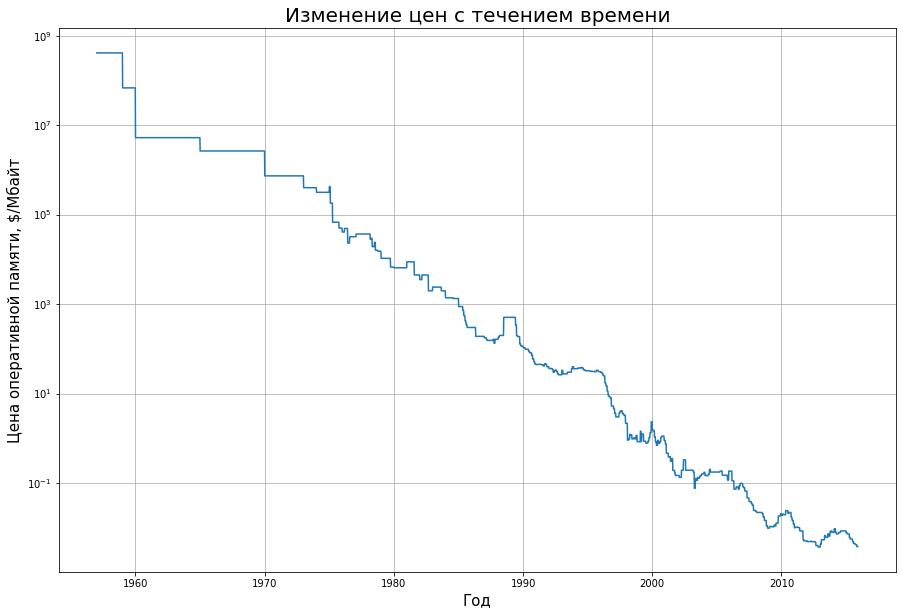

In [22]:
fig, ax1 = plt.subplots(1,figsize=(15,10))
ax1.semilogy(DataReg['price'].loc[:])
ax1.grid()
ax1.set_title('Изменение цен с течением времени', fontsize = 20)
ax1.set_xlabel('Год', fontsize = 15)
ax1.set_ylabel('Цена оперативной памяти, $/Мбайт', fontsize = 15); # вот эта вот точка с запятой помогает не выводить лишние строки текста 

2. Дополнительная/аддитивная декомпозиция (мой любимый способ фарма слайдов)

,Seasonality,Trend,Residual,Actual_values
date_conv,,,,
1957-01-06,-3.282057e+06,411041792.0,3.282057e+06,411041792.0
1957-01-13,-3.193654e+06,411041792.0,3.193654e+06,411041792.0
1957-01-20,-3.093716e+06,411041792.0,3.093716e+06,411041792.0
1957-01-27,-2.967328e+06,411041792.0,2.967328e+06,411041792.0
1957-02-03,-2.835646e+06,411041792.0,2.835646e+06,411041792.0


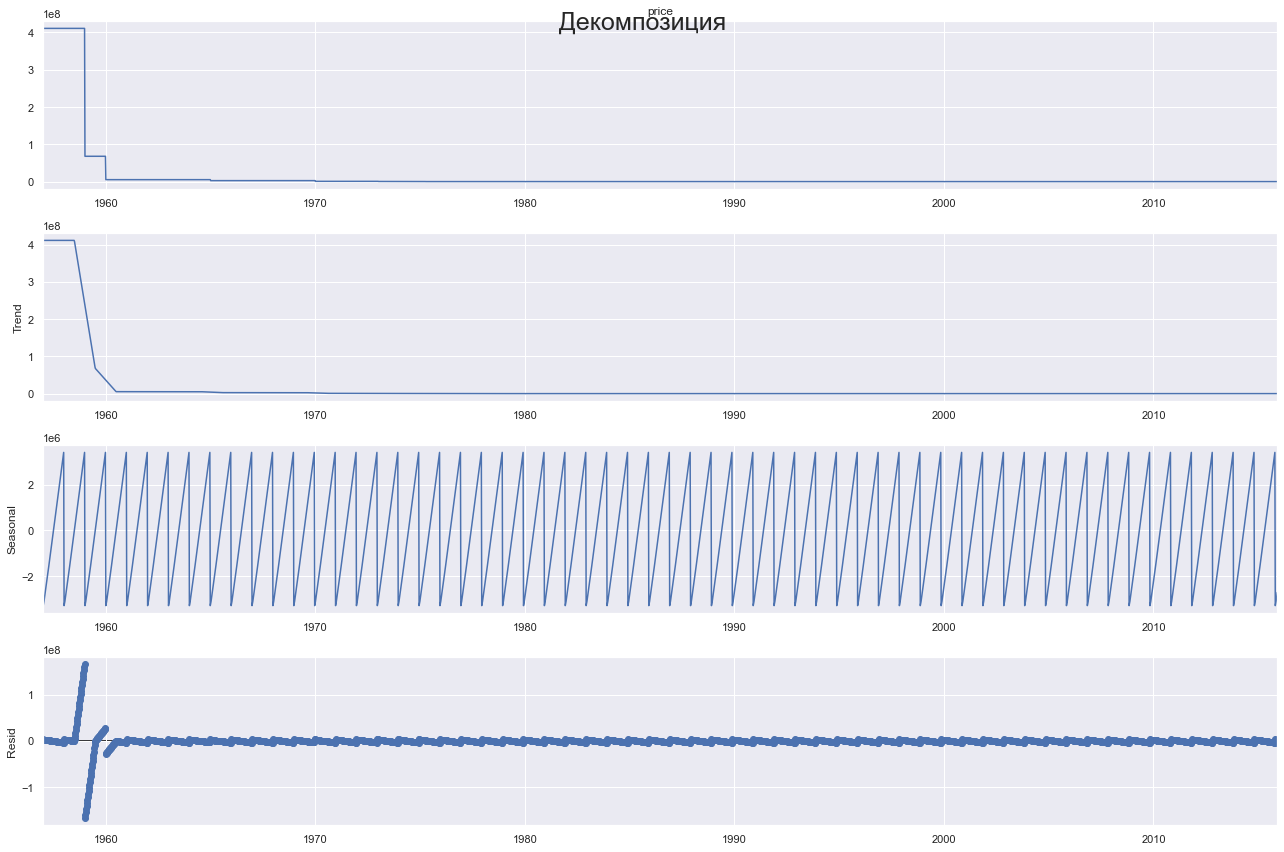

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(DataReg['price'], model='additive', extrapolate_trend='freq') # Декомпозиция

sns.set(rc={'figure.figsize':(18, 12)})
sns.set_style("darkgrid")
result_add.plot().suptitle('Декомпозиция', fontsize=25)

# Выделим Сезонность, Тренд, Остаток после удаления тренда
# Actual Values = Addition of (Seasonality + Trend + Residual)

df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['Seasonality', 'Trend', 'Residual', 'Actual_values']

# Скопируем случайные остатки в другую переменную
ResTime = df_reconstructed[['Residual']]

df_reconstructed.head()

In [24]:
df_reconstructed['Trend'].shape

(3074,)

Надеяться на эту декомпозицию не стоит - она слишком корявая

3. Скользящее среднее окно

По месяцам

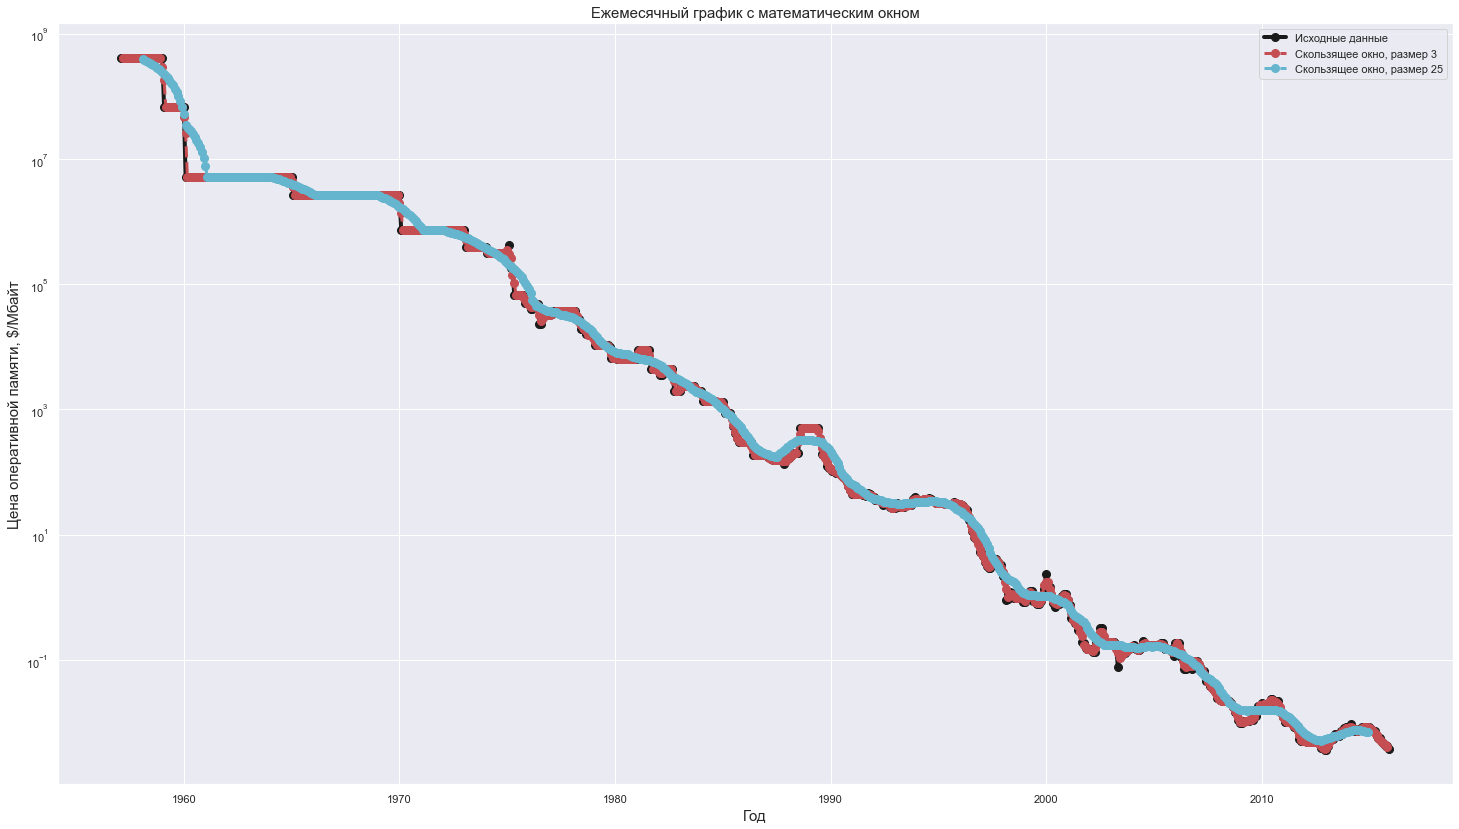

In [25]:
fig, ax = plt.subplots(figsize=(25,14))

ax.semilogy(DataReg['price'].resample('M').mean(), marker='o', markersize=8, linestyle='-',label='Исходные данные',linewidth=4,color='k')
ax.semilogy(DataReg['price'].resample('M').mean().rolling(window=3,center=True).mean(), marker='o', markersize=8, linestyle='--', label='Скользящее окно, размер 3',linewidth=3,color='r')
ax.semilogy(DataReg['price'].resample('M').mean().rolling(window=25, center=True).mean(beta=10), marker='o', linestyle='--', label='Скользящее окно, размер 25',linewidth=3,markersize=8,color='c')
ax.set_title('Ежемесячный график с математическим окном', fontsize = 15)
ax.set_xlabel('Год', fontsize = 15)
ax.set_ylabel('Цена оперативной памяти, $/Мбайт', fontsize = 15)
ax.legend();

По неделям

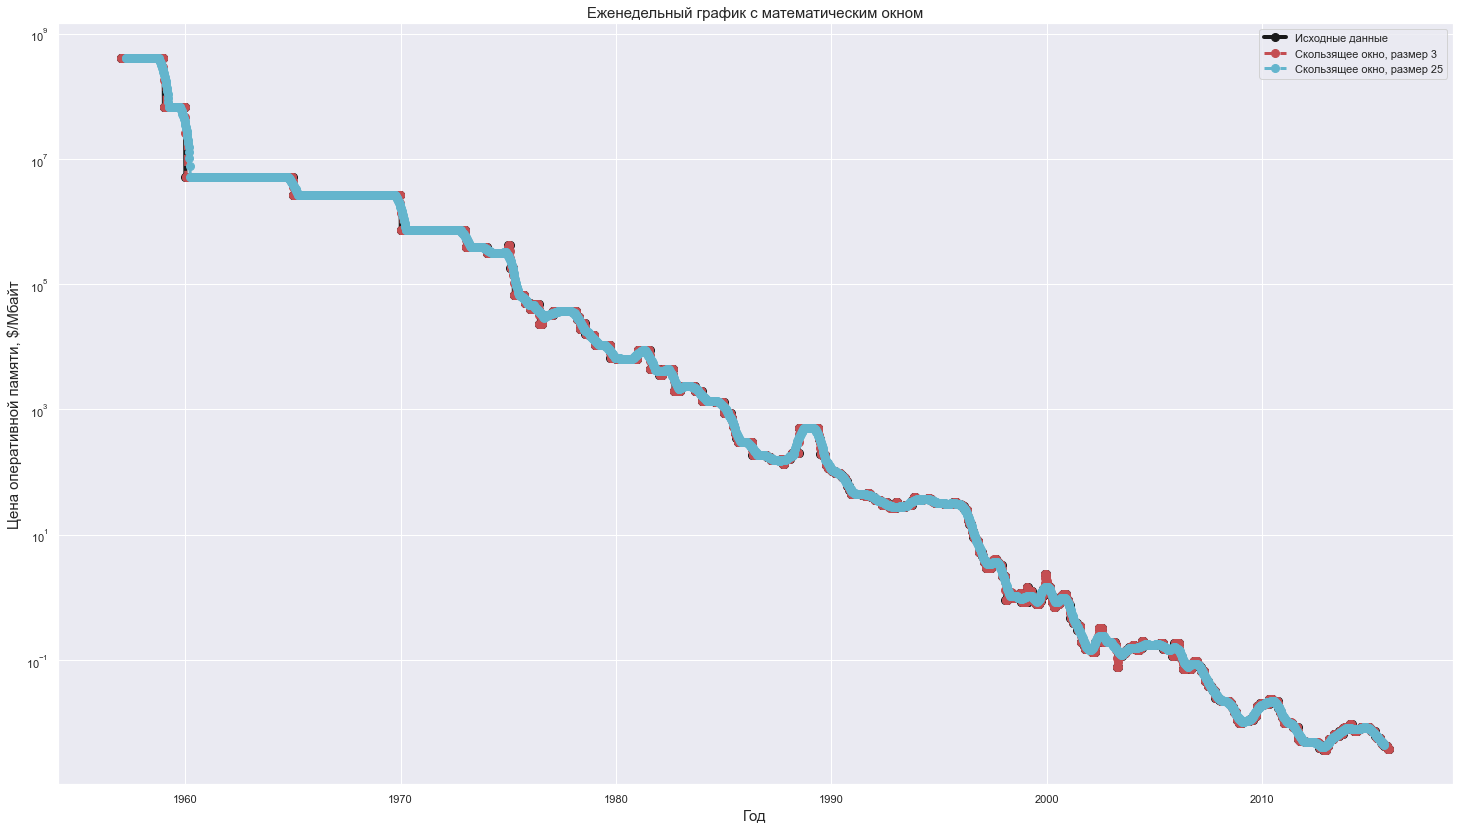

In [26]:
fig, ax = plt.subplots(figsize=(25,14))

ax.semilogy(DataReg['price'], marker='o', markersize=8, linestyle='-',label='Исходные данные',linewidth=4,color='k')
ax.semilogy(DataReg['price'].rolling(window=3,center=True).mean(), marker='o', markersize=8, linestyle='--', label='Скользящее окно, размер 3',linewidth=3,color='r')
ax.semilogy(DataReg['price'].rolling(window=25, center=True).mean(beta=10), marker='o', linestyle='--', label='Скользящее окно, размер 25',linewidth=3,markersize=8,color='c')
ax.set_title('Еженедельный график с математическим окном', fontsize = 15)
ax.set_xlabel('Год', fontsize = 15)
ax.set_ylabel('Цена оперативной памяти, $/Мбайт', fontsize = 15)
ax.legend();

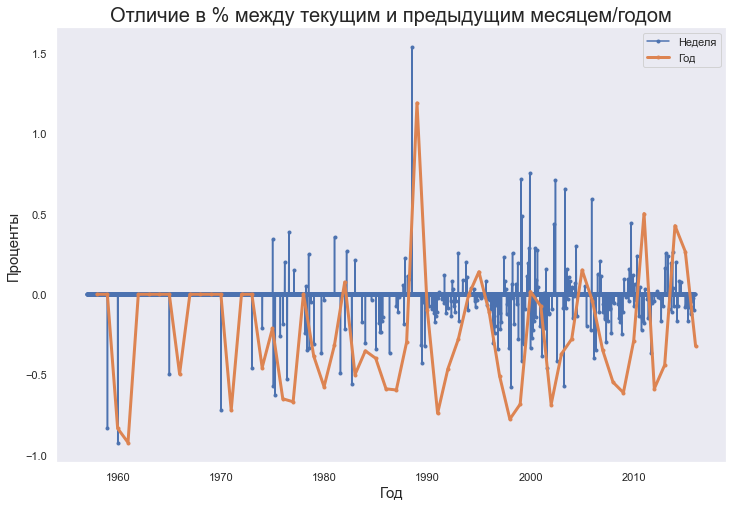

In [27]:
# отличие (в %)  между текущим и предыдущим эл-тами

fig, ax1 = plt.subplots(1,figsize=(12,8))
ax1.plot(DataReg['price'].resample('W').mean().pct_change().fillna(0), marker='o', markersize=3, label = 'Неделя')
ax1.plot(DataReg['price'].resample('Y').mean().pct_change().fillna(0), linewidth=3, marker='o', markersize=3, label = 'Год')
ax1.grid()
ax1.set_title('Отличие в % между текущим и предыдущим месяцем/годом', fontsize = 20);
ax1.set_xlabel('Год', fontsize = 15)
ax1.set_ylabel('Проценты', fontsize = 15)
plt.legend();

Особо тут выводов не сделаешь, разве что, можно сказать, что сетка успешно составлена и збс работает, ну и по длинным ступенькам видно, что пандас реально сделал пустые недели и в них скопировал предыдущие значения.

# Предсказание, ща повангуем

Тупо будет спам разными моделями в надежде что-то предсказать

Все те операции, что происходили сверху тут нахер никому не всрались, так что я возьму исходные данные

Просто запусти функции ниже один раз, Артём, Рома, Игорёша, не надо их каждый раз запускать, я потом на стриме лично каждого в очко накажу

In [28]:
# проверка лучшей модели на тестовых данных
# воспользуемся также и стандартными функциями оценки качества:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4)) # R-квадрат
    print('MAE: ', round(mean_absolute_error,4)) # MAE =mean absolute error
    print('MSE: ', round(mse,4)) # MSE =mean Squared Error
    print('RMSE: ', round(np.sqrt(mse),4)) # Root Mean Squared Error

Инициализация моделей

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

models = []
models.append(('LR', LinearRegression()))
models.append(('MLPR', MLPRegressor(solver = 'lbfgs'))) #neural network
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

Наша метрика какая-то (АНАЛогична RMSE)

In [30]:
from sklearn.metrics import make_scorer

def msre(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(msre, greater_is_better = False)

# Предсказание временными рядами

Намечается лютый `фарм` слайдов

Тащемта я тут пытаюсь предсказать приколосы на временных данных а поэтому мои многоуважаемые друзьяшечки начинается лютый приколяс с временными рядосами

In [31]:
DataYes = DataReg   # Вы наверное спросите зачем эти тих-тих и прочие не понтуйся
                    # А я вам скажу, что если в обучающей выборке у нас один столбец с данными, то это говнище не считает
                    # А поэтому вернём всё как было в исходнике

In [32]:
DataReg

,Unnamed: 0,date,price
date_conv,,,
1957-01-06,0,1957.00,4.110418e+08
1957-01-13,0,1957.00,4.110418e+08
1957-01-20,0,1957.00,4.110418e+08
1957-01-27,0,1957.00,4.110418e+08
1957-02-03,0,1957.00,4.110418e+08
...,...,...,...
2015-11-01,331,2015.83,3.800000e-03
2015-11-08,331,2015.83,3.800000e-03
2015-11-15,331,2015.83,3.800000e-03


Мухлевание с данными, а именно создание обучающих и тестовых выборок ну и логарифмирование

In [33]:
X = DataYes.drop(['price'], axis = 1)
y = DataYes['price']

# Треин тест сплит делать не будет, т.к. в этой задаче он будет мешать
X_train = X.loc['1990':'1999']
y_train = y.loc['1990':'1999']

X_test = X.loc['2000':]  # Возьмём данные для теста с 2000 до последнего года (включ)
y_test = y.loc['2000':]

y_train = np.log(y_train) # Прологарифмируем цены 
y_test = np.log(y_test)

In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(521, 2)
(521,)
(831, 2)
(831,)


In [35]:
results = []
names = []
for name, model in models:
    tscv = TimeSeriesSplit(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: -56.342389 (80.810396)
MLPR: -52.207810 (55.176034)
KNN: -3.328726 (4.073298)
RF: -2.637636 (3.425862)
SVR: -78.368073 (119.685286)


In [36]:
# print(X_train[:10])
# print(X_test[:10])
# print(y_train[:10])
# print(y_test[:10])

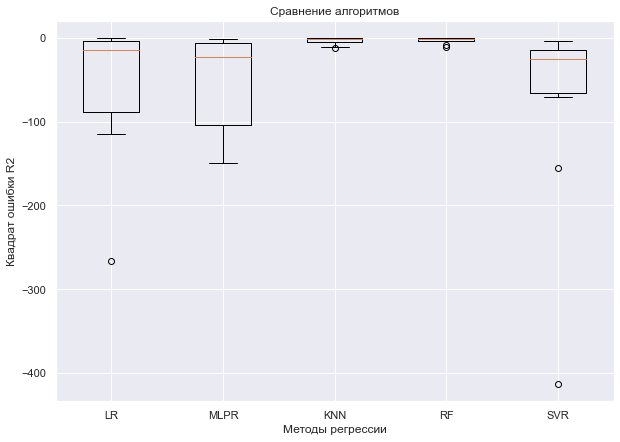

In [37]:
# Compare Algorithms
fig = plt.subplots(figsize = (10,7))
plt.boxplot(results, labels=names)
plt.title('Сравнение алгоритмов')
plt.ylabel('Квадрат ошибки R2')
plt.xlabel('Методы регрессии')
plt.show()

Из этих графиков можно понять, что все модели кроме KNN и RF херовенько работают

Ну и по классике берём *типа* случайный лес

In [38]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()
param_search = {'n_estimators': [10, 20, 30, 40],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [i for i in range(1,10)]}

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)

gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_ # лучшая модель

In [39]:
print(gsearch.best_params_)

{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 20}


Проверка лучшей модели на тестовых данных - расчет стандартных функций качества

In [40]:
y_train = np.exp(y_train) # Обратим логарифм обратно, а то не будет работать
y_test = np.exp(y_test)

In [41]:
# Нипасредсна предсказание и вывод той байды с разными точностями
y_true = y_test
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.0
mean_squared_log_error:  0.2842
r2:  -7.4013
MAE:  0.7364
MSE:  0.5739
RMSE:  0.7576


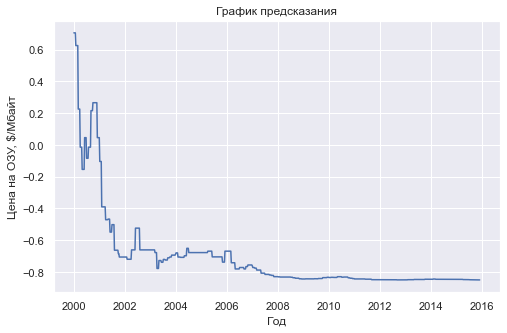

In [42]:
# визуализация ошибки предсказания ППЭ
fig, ax = plt.subplots(figsize=(8,5))
plt.title('График предсказания')
plt.ylabel('Цена на ОЗУ, $/Мбайт')
plt.xlabel('Год')
plt.plot(y_true-y_pred);

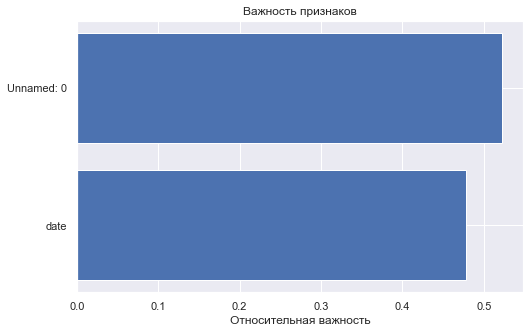

In [43]:
# проверка важности признаков
fig = plt.subplots(figsize = (8,5))
imp = best_model.feature_importances_ # рассчет значений важности признаков (от 0 до 1)
features = X_train.columns
indices = np.argsort(imp) # выдает индексы эл-тов массива по их возрастанию
plt.title('Важность признаков')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Относительная важность');

# Трюк с пальцами (♂AnalFingering♂)

Добавим признак "вчера"

In [44]:
DataReg 

,Unnamed: 0,date,price
date_conv,,,
1957-01-06,0,1957.00,4.110418e+08
1957-01-13,0,1957.00,4.110418e+08
1957-01-20,0,1957.00,4.110418e+08
1957-01-27,0,1957.00,4.110418e+08
1957-02-03,0,1957.00,4.110418e+08
...,...,...,...
2015-11-01,331,2015.83,3.800000e-03
2015-11-08,331,2015.83,3.800000e-03
2015-11-15,331,2015.83,3.800000e-03


In [45]:
DataYes = DataReg

DataYes.loc[:,'Yesterday'] = DataYes.loc[:,'date'].shift()
DataYes

,Unnamed: 0,date,price,Yesterday
date_conv,,,,
1957-01-06,0,1957.00,4.110418e+08,NaN
1957-01-13,0,1957.00,4.110418e+08,1957.00
1957-01-20,0,1957.00,4.110418e+08,1957.00
1957-01-27,0,1957.00,4.110418e+08,1957.00
1957-02-03,0,1957.00,4.110418e+08,1957.00
...,...,...,...,...
2015-11-01,331,2015.83,3.800000e-03,2015.75
2015-11-08,331,2015.83,3.800000e-03,2015.83
2015-11-15,331,2015.83,3.800000e-03,2015.83


In [46]:
X_train_Yest = DataYes.loc['1990':'1999'].drop(columns = ['price'], axis = 1)
y_train_Yest = DataYes.loc['1990':'1999', 'price']
X_test_Yest = DataYes.loc['2000':].drop(columns = ['price'], axis = 1)
y_test_Yest = DataYes.loc['2000':, 'price']

y_train_Yest = np.log(y_train_Yest)
y_test_Yest = np.log(y_test_Yest)

In [47]:
# Оценить каждую модель по очереди

results = []
names = []

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=5)
    cv_results = cross_val_score(model, X_train_Yest, y_train_Yest, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# fig = plt.subplots(figsize = (10,7))
# plt.plot(results)
# plt.legend(names)
# plt.show()

LR: -20.763684 (23.352511)
MLPR: -24.468438 (28.757784)
KNN: -3.141705 (2.405119)
RF: -3.016166 (2.352226)
SVR: -32.606013 (44.978841)


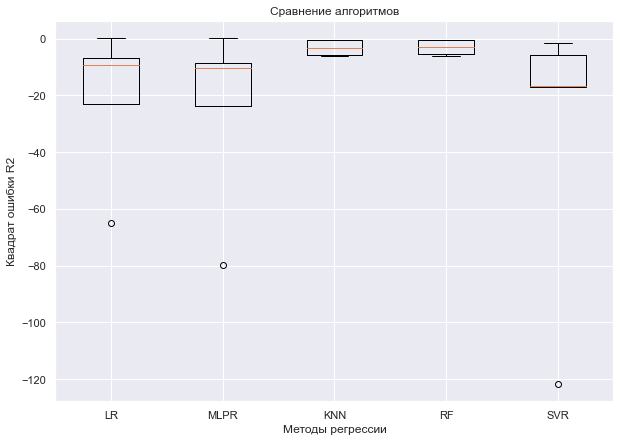

In [48]:
# Compare Algorithms
fig = plt.subplots(figsize = (10,7))
plt.boxplot(results, labels=names)
plt.title('Сравнение алгоритмов')
plt.ylabel('Квадрат ошибки R2')
plt.xlabel('Методы регрессии');

Всё по классике - лес наше всё

Опять берём нестабильный лес

In [49]:
y_train_Yest = np.exp(y_train_Yest) # Обратим логарифм обратно, а то не будет работать
y_test_Yest = np.exp(y_test_Yest)

In [50]:
model = RandomForestRegressor()
param_search = {'n_estimators': [10, 20, 30, 40],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [i for i in range(1,10)]}

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)

gsearch.fit(X_train_Yest, y_train_Yest)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_ # лучшая модель

In [51]:
print(gsearch.best_params_)

{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 30}


Проверка лучшей модели на тестовых данных - расчет стандартных функций качества

In [52]:
# Нипасредсна предсказание и вывод той байды с разными точностями
y_true = y_test_Yest
y_pred = best_model.predict(X_test_Yest)
# Результаты регрессии пока что не работают, так шо потом
regression_results(y_true, y_pred)

explained_variance:  0.0
mean_squared_log_error:  0.9385
r2:  -45.5764
MAE:  1.7645
MSE:  3.1819
RMSE:  1.7838


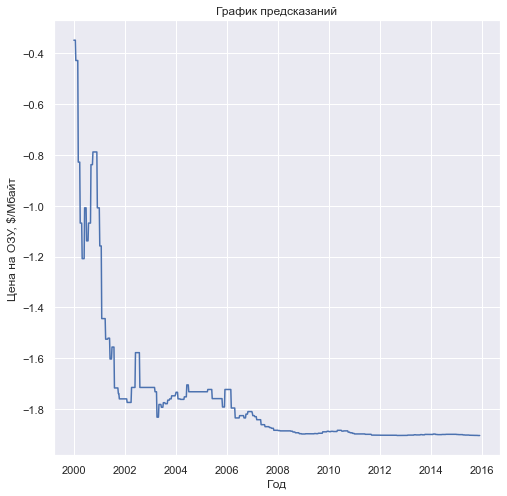

In [53]:
# визуализация ошибки предсказания ППЭ
fig, ax = plt.subplots(figsize=(8,8))
plt.title('График предсказаний')
plt.ylabel('Цена на ОЗУ, $/Мбайт')
plt.xlabel('Год')
plt.plot(y_true-y_pred);

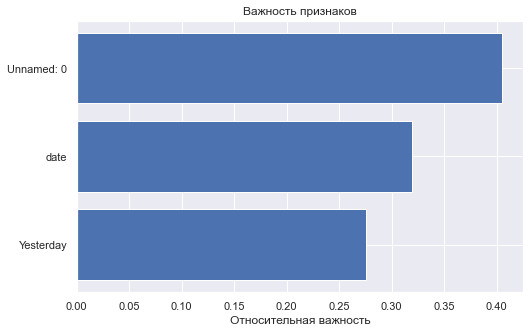

In [54]:
# проверка влажности признаков
fig = plt.subplots(figsize = (8,5))
imp = best_model.feature_importances_ # рассчет значений важности признаков (от 0 до 1)
features = X_train_Yest.columns
indices = np.argsort(imp) # выдает индексы эл-тов массива по их возрастанию
plt.title('Важность признаков')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Относительная важность');

# Добавим смещение на неделю (♂AnalFisting♂)

In [55]:
DataYes = DataReg

DataYes.loc[:,'Yesterday'] = DataYes.loc[:,'date'].shift()
DataYes.loc[:,'Yesterday_Week'] = DataYes.loc[:,'date'].shift(7)
DataYes

,Unnamed: 0,date,price,Yesterday,Yesterday_Week
date_conv,,,,,
1957-01-06,0,1957.00,4.110418e+08,NaN,NaN
1957-01-13,0,1957.00,4.110418e+08,1957.00,NaN
1957-01-20,0,1957.00,4.110418e+08,1957.00,NaN
1957-01-27,0,1957.00,4.110418e+08,1957.00,NaN
1957-02-03,0,1957.00,4.110418e+08,1957.00,NaN
...,...,...,...,...,...
2015-11-01,331,2015.83,3.800000e-03,2015.75,2015.67
2015-11-08,331,2015.83,3.800000e-03,2015.83,2015.67
2015-11-15,331,2015.83,3.800000e-03,2015.83,2015.67


In [56]:
X_train_Yest = DataYes.loc['1990':'1999'].drop(columns = ['price'], axis = 1)
y_train_Yest = DataYes.loc['1990':'1999', 'price']
X_test_Yest = DataYes.loc['2000':].drop(columns = ['price'], axis = 1)
y_test_Yest = DataYes.loc['2000':, 'price']

y_train_Yest = np.log(y_train_Yest)
y_test_Yest = np.log(y_test_Yest)

In [57]:
# Оценить каждую модель по очереди

results = []
names = []

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=5)
    cv_results = cross_val_score(model, X_train_Yest, y_train_Yest, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# fig = plt.subplots(figsize = (10,7))
# plt.plot(results)
# plt.legend(names)
# plt.show()

LR: -20.590054 (23.162545)
MLPR: -24.464597 (28.748924)
KNN: -3.141705 (2.405119)
RF: -3.080194 (2.416150)
SVR: -32.162050 (44.274480)


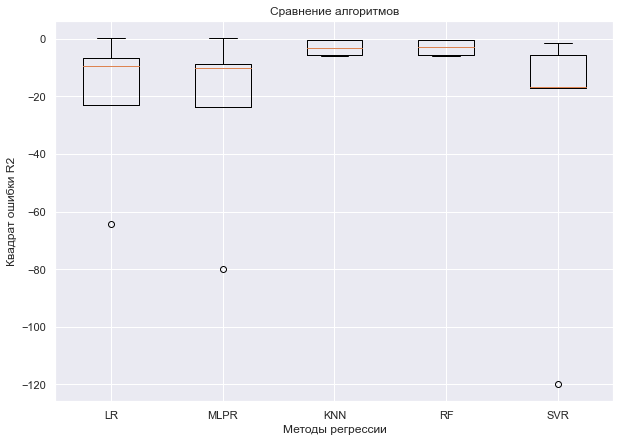

In [58]:
# Compare Algorithms
fig = plt.subplots(figsize = (10,7))
plt.boxplot(results, labels=names)
plt.title('Сравнение алгоритмов')
plt.ylabel('Квадрат ошибки R2')
plt.xlabel('Методы регрессии');

Снова берём не типа как бы ёпты случайный сука лес

In [59]:
y_train_Yest = np.exp(y_train_Yest) # Обратим логарифм обратно, а то не будет работать
y_test_Yest = np.exp(y_test_Yest)

In [60]:
model = RandomForestRegressor()
param_search = {'n_estimators': [3, 4, 5, 8, 10],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [i for i in range(1,10)]}

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)

gsearch.fit(X_train_Yest, y_train_Yest)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_ # лучшая модель

In [61]:
print(gsearch.best_params_)

{'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 3}


Проверка лучшей модели на тестовых данных - расчет стандартных функций качества

In [62]:
# Нипасредсна предсказание и вывод той байды с разными точностями
y_true = y_test_Yest
y_pred = best_model.predict(X_test_Yest)
# Результаты регрессии пока что не работают, так шо потом
regression_results(y_true, y_pred)

explained_variance:  0.0
mean_squared_log_error:  1.228
r2:  -71.2767
MAE:  2.2067
MSE:  4.9377
RMSE:  2.2221


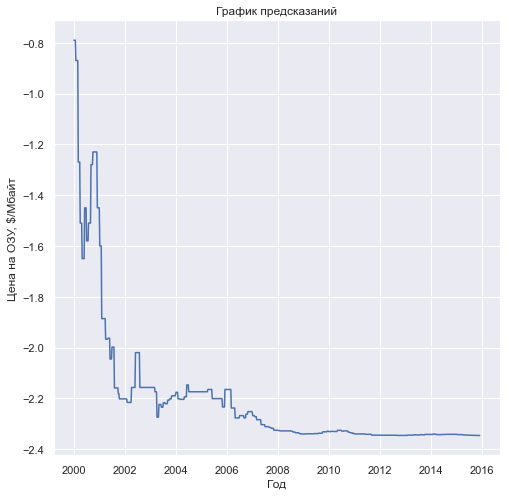

In [63]:
# визуализация ошибки предсказания ППЭ
fig, ax = plt.subplots(figsize=(8,8))
plt.title('График предсказаний')
plt.ylabel('Цена на ОЗУ, $/Мбайт')
plt.xlabel('Год')
plt.plot(y_true-y_pred);

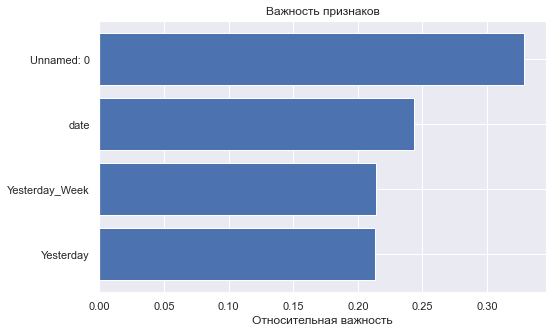

In [64]:
# проверка влажности признаков
fig = plt.subplots(figsize = (8,5))
imp = best_model.feature_importances_ # рассчет значений важности признаков (от 0 до 1)
features = X_train_Yest.columns
indices = np.argsort(imp) # выдает индексы эл-тов массива по их возрастанию
plt.title('Важность признаков')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Относительная важность');

Щас ваще будет контент ахереете

# Обычные работяжные модели

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

In [66]:
DataRabPd = data.drop('date_conv', axis = 1)
DataRab = np.array(DataRabPd)
DataRabPd[:5]

,Unnamed: 0,date,price
0,0,1957.0,411041792.0
1,1,1959.0,67947725.0
2,2,1960.0,5242880.0
3,3,1965.0,2642412.0
4,4,1970.0,734003.0


Создадим обуч\тест выборки

In [67]:
train1, test1 = DataRab[100:251], DataRab[250:]
X_all = DataRab[100:][:,1].reshape(-1,1)

In [68]:
Xtrain, Xtest = train1[:,1].reshape(-1,1), test1[:,1].reshape(-1,1)
ytrain, ytest = np.log(train1[:,-1].reshape(-1,1)), np.log(test1[:,-1].reshape(-1,1))

Обучим всю эту блевоту

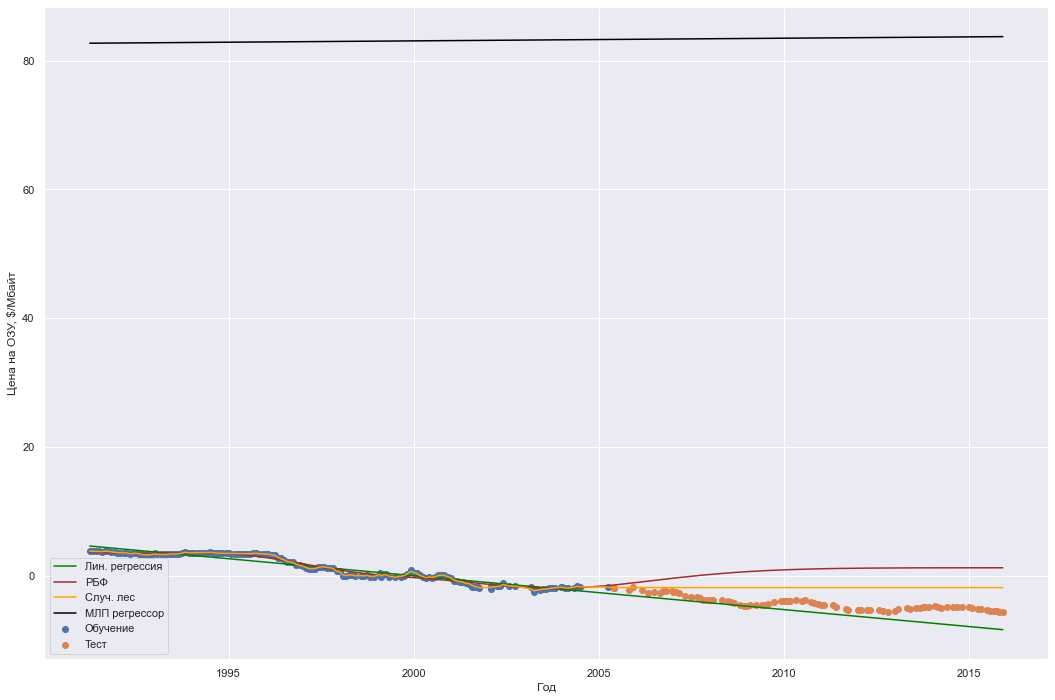

In [69]:
model1 = LinearRegression().fit(Xtrain, ytrain)
model2 = SVR(kernel = 'rbf').fit(Xtrain, ytrain)
model3 = RandomForestRegressor().fit(Xtrain, ytrain)
model4 = MLPRegressor().fit(Xtrain, ytrain)

lin = model1.predict(X_all)
rbf = model2.predict(X_all)
rf = model3.predict(X_all)
mlp = model4.predict(X_all)

plt.scatter(Xtrain, ytrain, label = 'Обучение')
plt.scatter(Xtest, ytest, label = 'Тест')
plt.xlabel('Год')
plt.ylabel('Цена на ОЗУ, $/Мбайт')

plt.plot(X_all, lin, color = 'green', label = 'Лин. регрессия')
plt.plot(X_all, rbf, color = 'brown', label = 'РБФ')
plt.plot(X_all, rf, color = 'orange', label = 'Случ. лес')
plt.plot(X_all, mlp, color = 'black', label = 'МЛП регрессор')
plt.legend();

In [70]:
from sklearn.metrics import r2_score

print('LinReg :', r2_score(ytest, lin[len(Xtrain)-1:]))
print('RBF :', r2_score(ytest, rbf[len(Xtrain)-1:]))
print('RF :', r2_score(ytest, rf[len(Xtrain)-1:]))
print('MLP :', r2_score(ytest, mlp[len(Xtrain)-1:]))

LinReg : -1.7193322428805726
RBF : -25.449977576887928
RF : -5.7107743362893375
MLP : -7445.081730963634


Сейчас применим диффиренцирование и обучим на таких данных наши модели. Такие данные не имеют тренда и лучше усваиваются моделями.

In [71]:
DataRab1 = DataRabPd
# DataRab1['price'] = np.log(DataRabPd['price'])
DataRab1['price_diff'] = DataRabPd['price'].diff()
DataRab1 = DataRab1.dropna()
DataRab1 = np.array(DataRab1)

In [72]:
train1, test1 = DataRab1[100:251], DataRab1[250:]
X_all = DataRab1[100:][:,1].reshape(-1,1)

In [73]:
Xtrain, Xtest = train1[:,1].reshape(-1,1), test1[:,1].reshape(-1,1)
ytrain, ytest = train1[:,-1].reshape(-1,1), test1[:,-1].reshape(-1,1)

Обучим всю эту блевоту

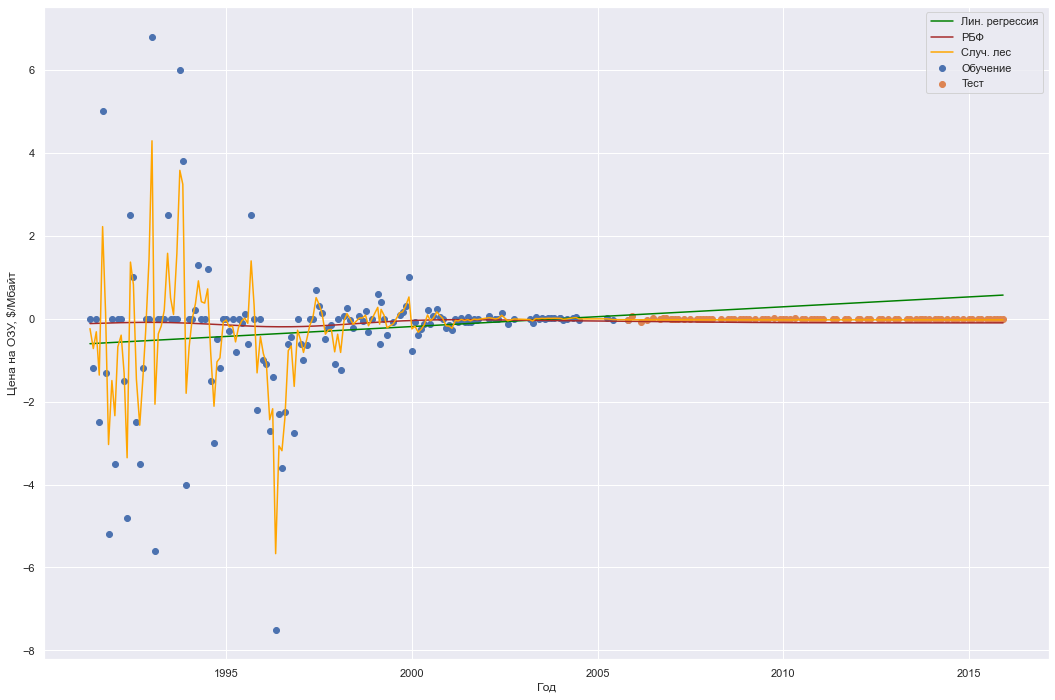

In [74]:
# Инициализация моделей
model1 = LinearRegression().fit(Xtrain, ytrain)
model2 = SVR(kernel = 'rbf', C = 0.1).fit(Xtrain, ytrain)
model3 = RandomForestRegressor().fit(Xtrain, ytrain)
# model4 = MLPRegressor().fit(Xtrain, ytrain)

# Предсказание
lin = model1.predict(X_all)
rbf = model2.predict(X_all)
rf = model3.predict(X_all)
# mlp = model4.predict(X_all)

# Рисование обуч., теста, инфы по осям
plt.scatter(Xtrain, ytrain, label = 'Обучение')
plt.scatter(Xtest, ytest, label = 'Тест')
plt.xlabel('Год')
plt.ylabel('Цена на ОЗУ, $/Мбайт')

# Рисование графиков моделей
plt.plot(X_all, lin, color = 'green', label = 'Лин. регрессия')
plt.plot(X_all, rbf, color = 'brown', label = 'РБФ')
plt.plot(X_all, rf, color = 'orange', label = 'Случ. лес')
# plt.plot(X_all, mlp, color = 'black', label = 'МЛП регрессор')
plt.legend();

In [75]:
print('LinReg :', r2_score(ytest, lin[len(Xtrain)-1:]))
print('RBF :', r2_score(ytest, rbf[len(Xtrain)-1:]))
print('RF :', r2_score(ytest, rf[len(Xtrain)-1:]))
# print('MLP :', r2_score(ytest, mlp[len(Xtrain)-1:]))

LinReg : -759.9620459341835
RBF : -50.30584216553243
RF : -4.255714870885572


# ARIMA

Сразу говорю тут очень много и я не шарю что тут происходит, даже щебень не шарит

In [76]:
DataAr = DataReg['price'] # Только это нам понадобится

# SARIMAX

In [77]:
# для проверки на стационарность тестом ADF - загрузить это
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.api import qqplot
import statsmodels.api as sm

In [78]:
from  statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot

Автокорреляция

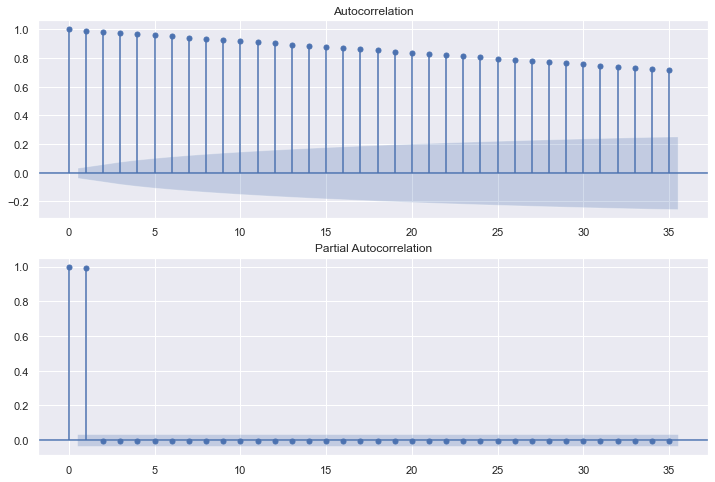

In [79]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(DataAr.values.squeeze(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(DataAr, ax=ax2)

In [80]:
# разделим данные в пропорции 0.8/0.2
train_size = 0.8
split_idx = round(len(DataAr)* train_size)   # теперь с лог.данными
train = DataAr.iloc[:split_idx]
test = DataAr.iloc[split_idx:]

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

In [82]:
import warnings
warnings.filterwarnings('ignore')

# параметры p, d, q задаем вручную. вроде из анализа автокорр. ACF и частичн.автокорреляции PACF
d = 2
p = 1
q = 0
base_model = SARIMAX(train).fit()
display(base_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 2459
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -42262.125
Date:                Fri, 18 Jun 2021   AIC                          84528.250
Time:                        11:49:30   BIC                          84539.865
Sample:                    01-06-1957   HQIC                         84532.470
                         - 02-15-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9991      0.000   4064.850      0.000       0.999       1.000
sigma2      4.901e+13   1.04e-18    4.7e+31      0.000     4.9e+13     4.9e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):         537286829.21
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                           -47.27
Prob(H) (two-sided):                  0.00   Kurtosis:                      2291.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.26e+45. Standard errors may be unstable.
"""

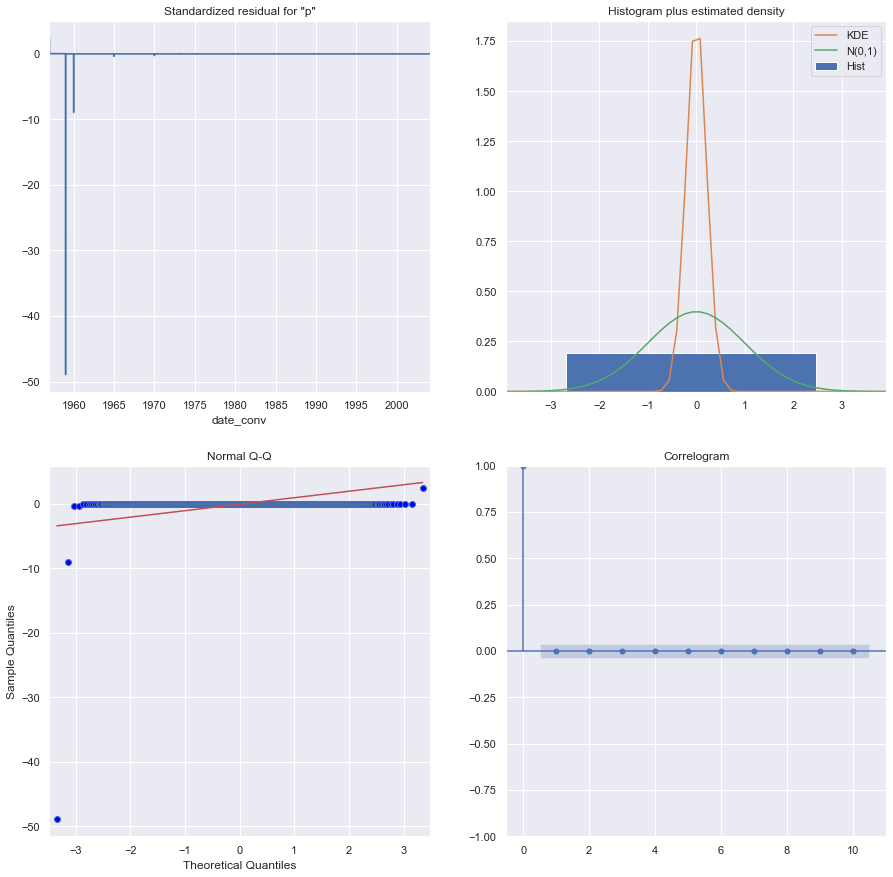

In [83]:
base_model.plot_diagnostics(figsize=(15,15));

In [84]:
# Model forecast = модель прогноза
# для прогноза в sarimax используетсz get_forecast (steps - кол-во отсчетов, которое берем из теста)
def forecast_to_df(model, steps=12):
    forecast = model.get_forecast(steps=steps) 
    pred_df = forecast.conf_int()
    pred_df['pred'] = forecast.predicted_mean
    pred_df.columns = ['lower', 'upper', 'pred']
    return pred_df

In [85]:
# работает
pred_df_Sari = forecast_to_df(base_model, steps=len(test)+220) # Прогноз на длину теста + 220 недель
pred_df_Sari.head()

,lower,upper,pred
2004-02-22,-1.372141e+07,1.372141e+07,0.147869
2004-02-29,-1.939645e+07,1.939645e+07,0.147739
2004-03-07,-2.374523e+07,2.374523e+07,0.147609
2004-03-14,-2.740654e+07,2.740654e+07,0.147478
2004-03-21,-3.062794e+07,3.062794e+07,0.147348


In [86]:
pred_df_Sari.info() # 53 строки - прогноз на 53 месяца

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835 entries, 2004-02-22 to 2020-02-16
Freq: W-SUN
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lower   835 non-null    float64
 1   upper   835 non-null    float64
 2   pred    835 non-null    float64
dtypes: float64(3)
memory usage: 26.1 KB


In [87]:
pred_df_Sari.loc[pred_df_Sari.iloc[-1].name,:]   # вывели последнюю строку таблицы

lower   -2.868694e+08
upper    2.868694e+08
pred     7.081396e-02
Name: 2020-02-16 00:00:00, dtype: float64

Это мера оценки точности 

In [88]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

pred = pred_df_Sari['pred']
# Calculate MSE
mse = mean_squared_error(pred.head(len(test)), test) # Сравниваем только те предсказание, которые входят в область теста
print('Средний квадрат ошибки :', mse)

Средний квадрат ошибки : 0.006752475950271007


In [89]:
# построим график прогноза, сравним с реалиями
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots(figsize=(12,7))
    kws = dict(marker='o')
    
    ax.semilogy(train,label='Обучение',**kws)
    ax.semilogy(test,label='Тест',**kws)
    ax.semilogy(pred_df['pred'],label='Предсказания',ls='--',linewidth=3)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'],alpha=0.3)
    ax.set_title('Работа модели', fontsize=22)
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig,ax

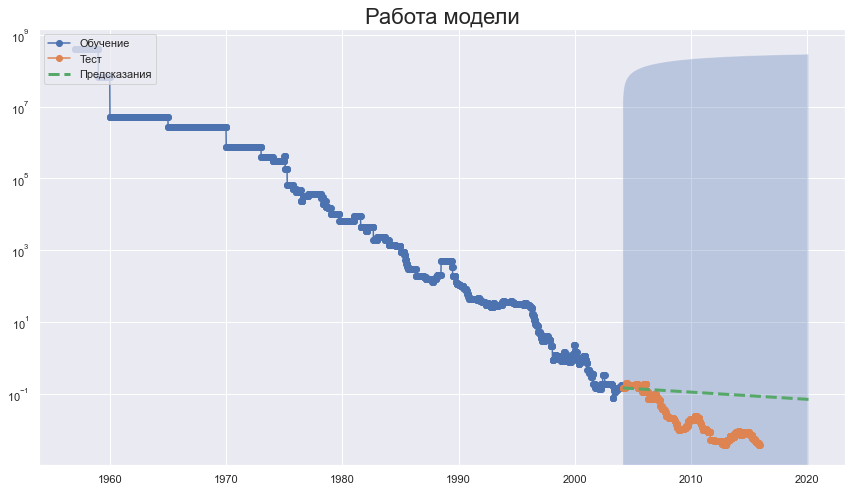

In [90]:
plot_train_test_pred(train,test,pred_df_Sari);

Сделаем `АРИМу по дням`

In [91]:
Data_Day = DataAr.asfreq(freq = 'D', method = 'ffill')
Data_Day.head # Первые пять строк

<bound method NDFrame.head of date_conv
1957-01-06    4.110418e+08
1957-01-07    4.110418e+08
1957-01-08    4.110418e+08
1957-01-09    4.110418e+08
1957-01-10    4.110418e+08
                  ...     
2015-11-25    3.800000e-03
2015-11-26    3.800000e-03
2015-11-27    3.800000e-03
2015-11-28    3.800000e-03
2015-11-29    3.800000e-03
Freq: D, Name: price, Length: 21512, dtype: float64>

In [92]:
train = Data_Day.iloc[:int(Data_Day.shape[0]*0.8)]
test = Data_Day.iloc[int(Data_Day.shape[0]*0.8):]

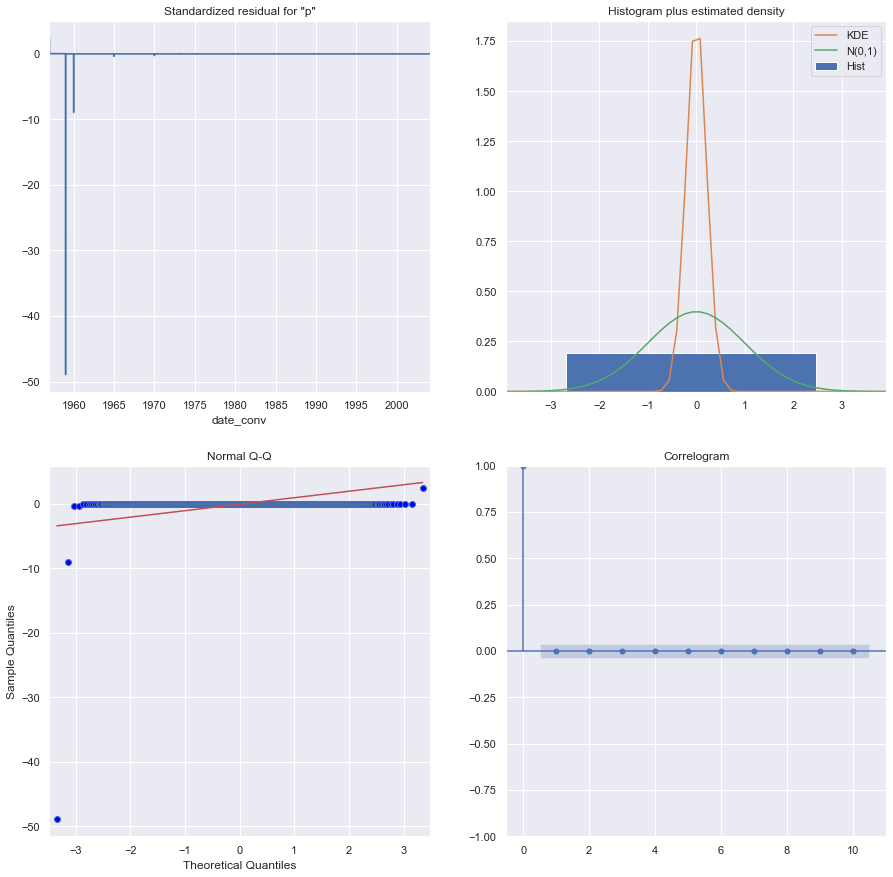

In [93]:
base_model.plot_diagnostics(figsize=(15,15));

In [94]:
# работает
base_model = SARIMAX(train).fit()
display(base_model.summary())

pred_df_Sari = forecast_to_df(base_model, steps=len(test) + 7*220) # Прогноз на длину теста + 5000 дней
pred_df_Sari.head()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                17209
Model:               SARIMAX(1, 0, 0)   Log Likelihood             -279003.906
Date:                Fri, 18 Jun 2021   AIC                         558011.813
Time:                        11:49:34   BIC                         558027.319
Sample:                    01-06-1957   HQIC                        558016.923
                         - 02-17-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997   3.32e-05   3.01e+04      0.000       1.000       1.000
sigma2       7.06e+12   8.65e-19   8.16e+30      0.000    7.06e+12    7.06e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):      185664961615.34
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                          -125.40
Prob(H) (two-sided):                  0.00   Kurtosis:                     16092.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.83e+43. Standard errors may be unstable.
"""

,lower,upper,pred
2004-02-18,-5.207717e+06,5.207718e+06,0.147948
2004-02-19,-7.363537e+06,7.363538e+06,0.147897
2004-02-20,-9.016878e+06,9.016879e+06,0.147845
2004-02-21,-1.040998e+07,1.040998e+07,0.147793
2004-02-22,-1.163667e+07,1.163667e+07,0.147741


In [95]:
pred_df_Sari.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5843 entries, 2004-02-18 to 2020-02-16
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lower   5843 non-null   float64
 1   upper   5843 non-null   float64
 2   pred    5843 non-null   float64
dtypes: float64(3)
memory usage: 182.6 KB


In [96]:
pred_df_Sari.loc[pred_df_Sari.iloc[-1].name,:]   # вывели последнюю строку таблицы

lower   -1.953011e+08
upper    1.953011e+08
pred     1.918523e-02
Name: 2020-02-16 00:00:00, dtype: float64

In [97]:
pred = pred_df_Sari['pred']
# Calculate MSE
mse = mean_squared_error(pred.head(len(test)), test)
print('Средний квадрат ошибки :', mse)

Средний квадрат ошибки : 0.0021095307449523638


In [98]:
# построим график прогноза, сравним с реалиями
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots(figsize=(12,7))
    kws = dict(marker='o')
    
    ax.semilogy(train,label='Обучение',**kws)
    ax.semilogy(test,label='Тест',**kws)
    ax.semilogy(pred_df['pred'],label='Предсказания',ls='--',linewidth=3)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'],alpha=0.3)
    ax.set_title('Работа модели', fontsize=22)
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig,ax

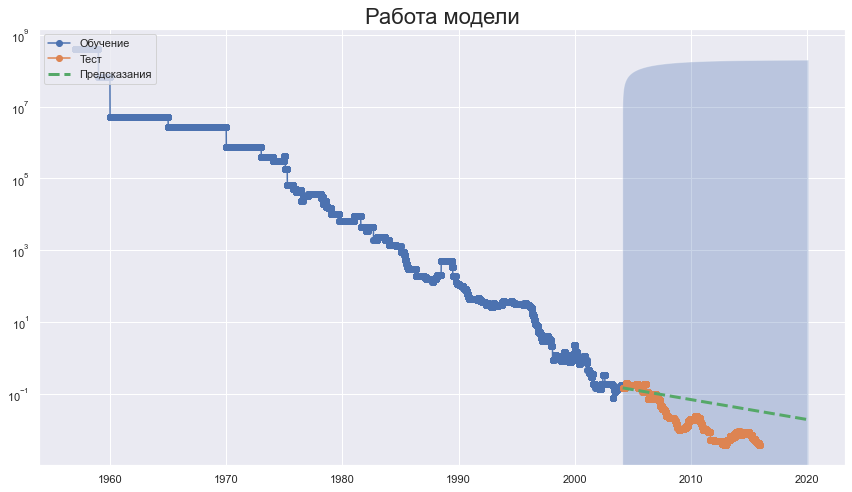

In [99]:
plot_train_test_pred(train,test,pred_df_Sari);

# Попробуем AutoReg

Обучение на обычных данных

In [100]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

DataFut = DataAr.loc['1980':'2010']

sel = ar_select_order(DataFut, 15, seasonal=False, old_names=False)
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                  price   No. Observations:                 1617
Model:                     AutoReg(1)   Log Likelihood              -10310.706
Method:               Conditional MLE   S.D. of innovations            142.801
Date:                Fri, 18 Jun 2021   AIC                              9.927
Time:                        11:49:36   BIC                              9.937
Sample:                    01-13-1980   HQIC                             9.930
                         - 12-26-2010                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5634      3.830      0.147      0.883      -6.943       8.070
price.L1       0.9937      0.002    501.942      0.000       0.990       0.998
                                    Roots           

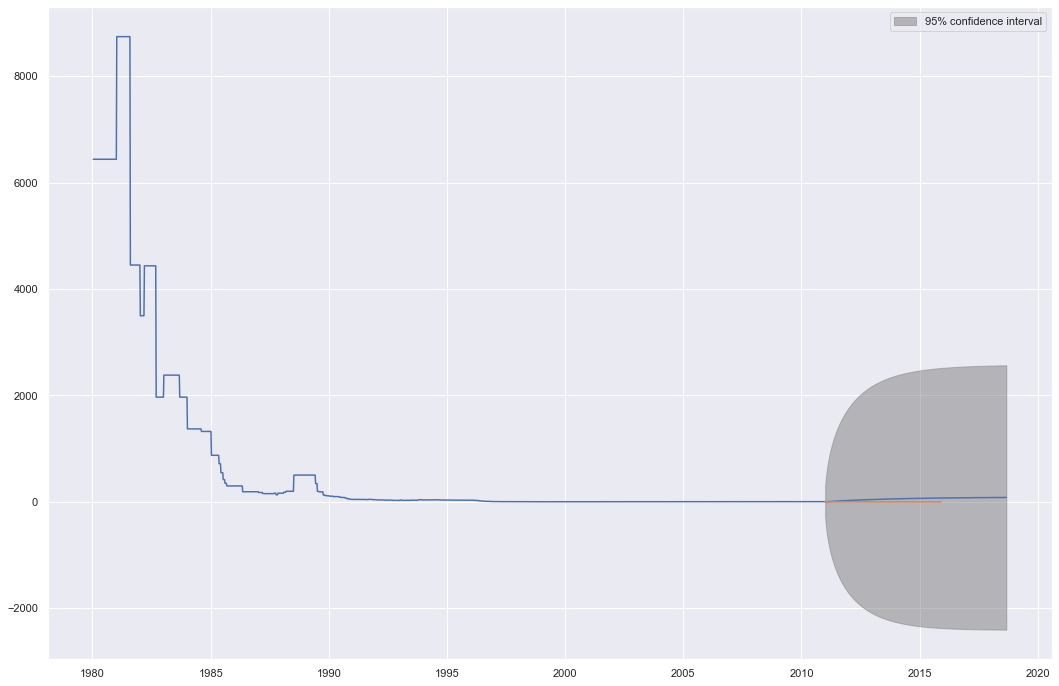

In [101]:
fig = res.plot_predict('1980', len(DataFut) + 400) # Предсказание на 400 недель вперёд
plt.plot(DataAr['2011':]);

Обучение на дифференцированных данных

In [102]:
DataFut = DataAr.loc['1980':'2010'].diff()
DataFut = DataFut.dropna(how='all')
DataFut.isna().sum()

0

In [103]:
sel = ar_select_order(DataFut, 15, seasonal=False, old_names=False)
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                  price   No. Observations:                 1616
Model:                     AutoReg(0)   Log Likelihood              -10315.791
Method:               Conditional MLE   S.D. of innovations            143.251
Date:                Fri, 18 Jun 2021   AIC                              9.932
Time:                        11:49:36   BIC                              9.938
Sample:                    01-13-1980   HQIC                             9.934
                         - 12-26-2010                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0099      3.563     -1.125      0.260     -10.994       2.974


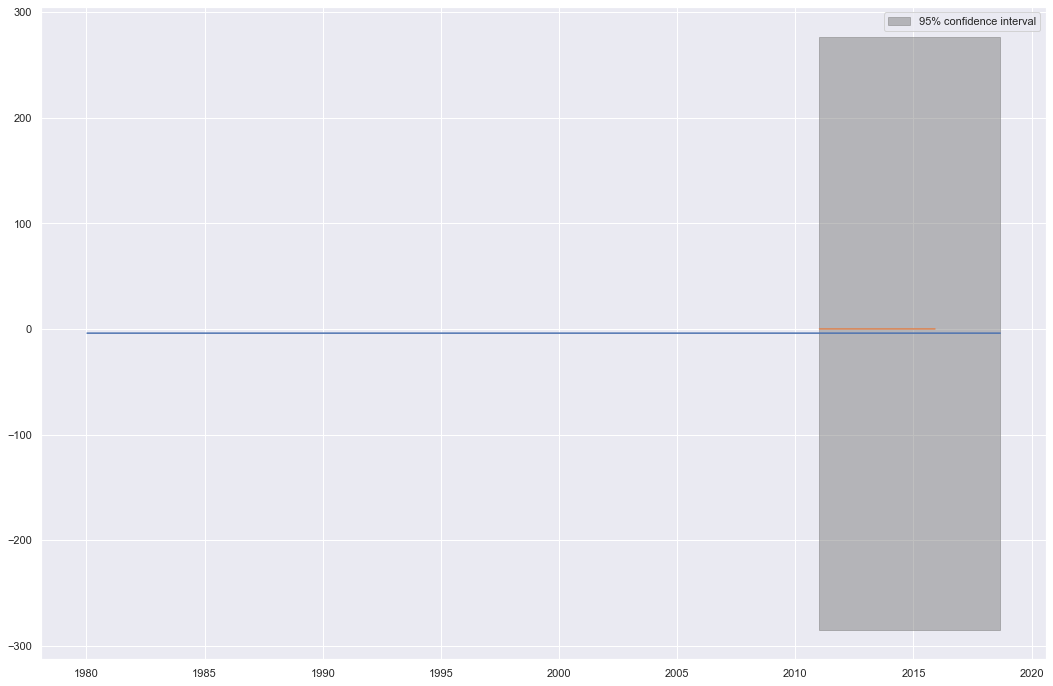

In [104]:
fig = res.plot_predict('1980', len(DataFut) + 400) # Предсказание на 400 недель вперёд
plt.plot(DataAr['2011':].diff());